In [1]:
from astroquery.vizier import Vizier

from astropy.io import fits
from astropy.table import QTable
from astropy import units as u

from astropy.visualization import quantity_support

from matplotlib import pyplot

from specutils import Spectrum1D, SpectralRegion
from specutils.analysis import gaussian_fwhm
from specutils.fitting import find_lines_derivative, fit_generic_continuum
from specutils.manipulation import extract_region

import numpy
import pandas

quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x2c23d844760>

In [2]:
# spec_catalogue = Vizier.get_catalogs('VI/120/files')[0]
# spec_catalogue

In [3]:
spec_file = '3500_00_m05p00.ms.fits.gz'
flux_units = u.Unit('erg cm-2 s-1 AA-1')
spec_start = 300 * u.nm
spec_end = 1.8 * u.micron
spec_region = SpectralRegion(654 * u.nm, 656 * u.nm)
# spec_region = SpectralRegion(434 * u.nm, 740 * u.nm)

In [4]:
spec_fits = fits.open(spec_file)
spec_flux = spec_fits[0].data[1] * flux_units
spec_len = len(spec_flux)
spec_wavelengths = numpy.linspace(spec_start, spec_end, num=spec_len)
spec = Spectrum1D(spectral_axis=spec_wavelengths, flux=spec_flux)

In [5]:
sub_spec = extract_region(spec, spec_region)
# sub_spec = sub_spec / fit_generic_continuum(sub_spec)(sub_spec.spectral_axis) 

In [6]:
# https://linelist.pa.uky.edu/newpage/

linelist = QTable.from_pandas(pandas.read_csv('linelist.csv').drop_duplicates())
linelist['Wavelength'] = linelist['Wavelength'] * u.nm
linelist = linelist[linelist['Wavelength'] >= spec_region.lower]
linelist = linelist[linelist['Wavelength'] <= spec_region.upper]

In [7]:
lines = find_lines_derivative(sub_spec, flux_threshold=-numpy.percentile(sub_spec.flux, 10))
lines = lines[lines['line_type'] == 'absorption']


If you want to suppress this warning either type 'specutils.conf.do_continuum_function_check = False' or see http://docs.astropy.org/en/stable/config/#adding-new-configuration-items for other ways to configure the warning. [specutils.analysis.flux]


In [8]:
# https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
def find_nearest(array, value):
    array = numpy.asarray(array)
    idx = (numpy.abs(array - value)).argmin()
    return idx

def detected_lines(spec_lines, line_list):
    line_list_values = line_list['Wavelength'].to(u.micron).value
    for spec_line in spec_lines:
        spec_line_value = spec_line['line_center'].to(u.micron).value
        nearest = find_nearest(line_list_values, spec_line_value)
        if numpy.isclose(line_list_values[nearest], spec_line_value):
            yield (
                spec_line['line_center'],
                line_list[nearest]['Wavelength'],
                line_list[nearest]['Element'],
                line_list[nearest]['Spectrum'],
            )

In [9]:
det_lines = list(zip(*list(detected_lines(lines, linelist))))
det_lines = QTable(
    data=det_lines,
    names=('Spectrum wavelength', 'Reference wavelength', 'Element', 'Spectrum'),
)
det_lines

Spectrum wavelength,Reference wavelength,Element,Spectrum
micron,nm,,
float64,float64,str1,str3
0.6549940071913704,654.99,C,III
0.6550499400719136,655.05,O,IV]
0.6552437075509389,655.2406,O,II
0.6556691969636437,655.667,O,I
0.655747103475829,655.7452,O,II
0.6559009188973232,655.9,C,II]


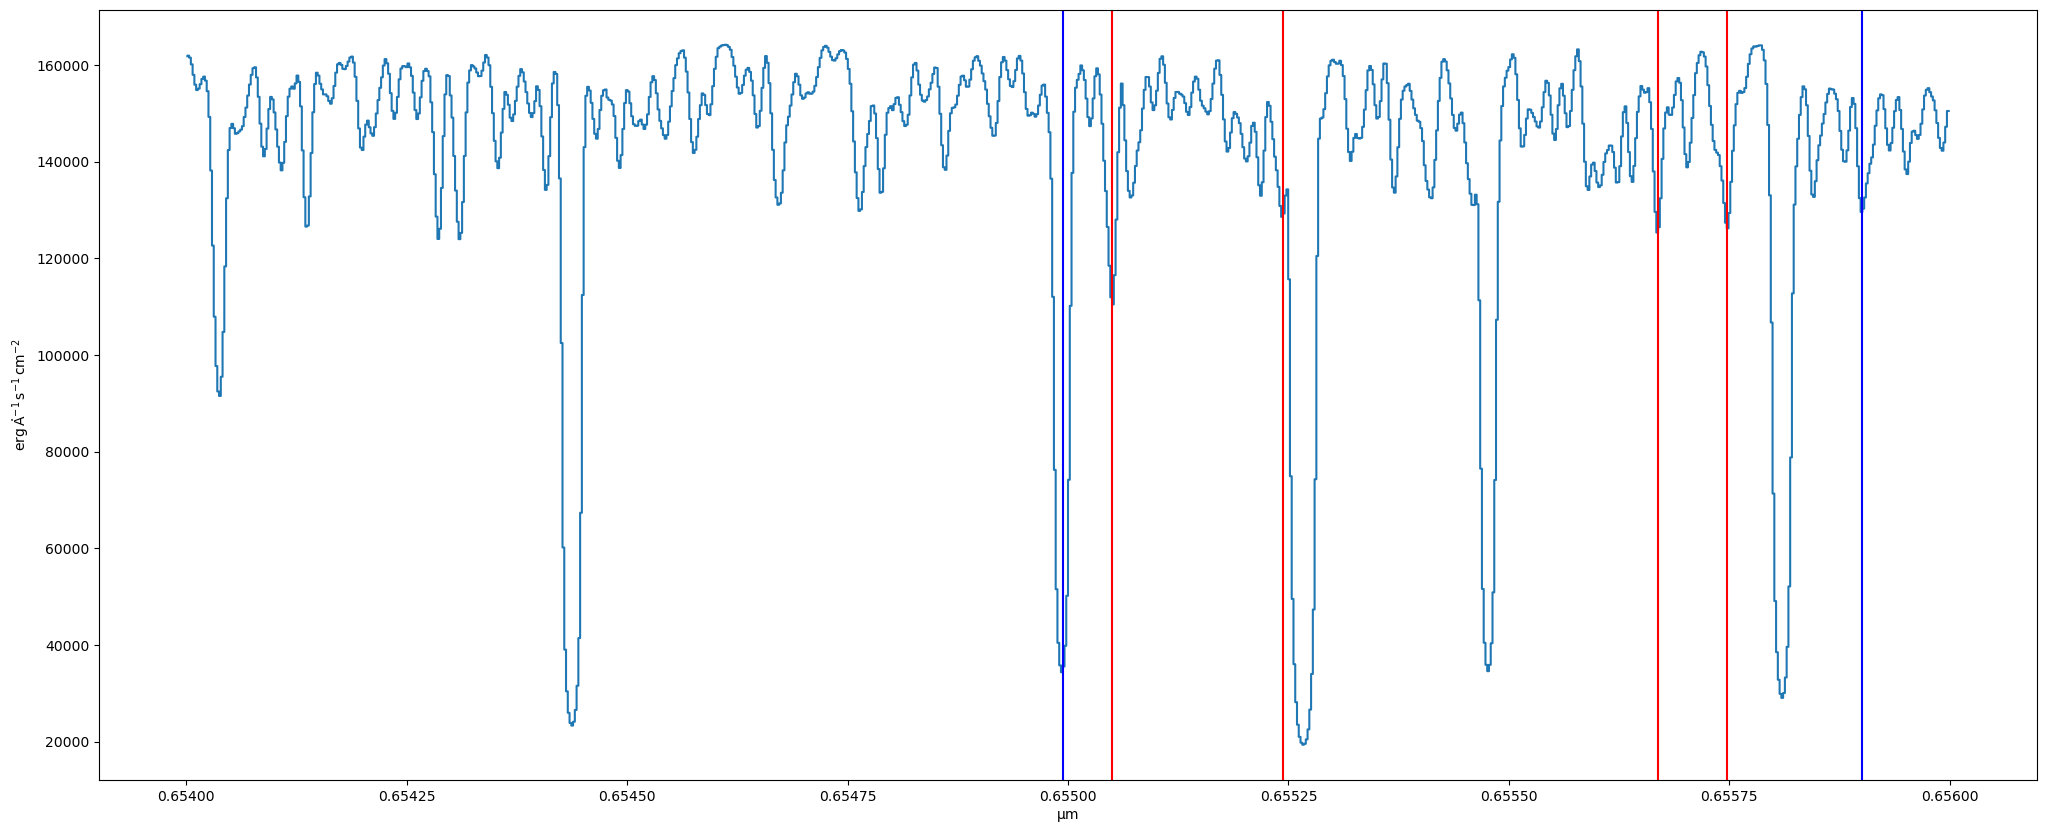

In [10]:
f = pyplot.figure(figsize=(25,10))  
pyplot.step(sub_spec.spectral_axis, sub_spec.flux) 

colours = {'C': 'blue', 'O': 'red'}

for row in det_lines:
    pyplot.axvline(row['Spectrum wavelength'], c=colours[row['Element']])